In [ ]:
pip show tensorflow

Name: tensorflow
Version: 2.19.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.12/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, tensorflow_decision_forests, tf_keras


Importaciones y configuración inicial

In [ ]:

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True


Montaje y carga de datos

In [ ]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')


# Ruta del dataset
base_dir = '/content/drive/MyDrive/Colab Notebooks/03.Etiquetado_PreValidado'

# Cargar imágenes y etiquetas
image_paths = []
octa_labels = []
for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    if not os.path.isdir(folder_path):
        continue
    try:
        octa = int(folder.split('_')[-1])
    except:
        continue
    for fname in os.listdir(folder_path):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(folder_path, fname))
            octa_labels.append(octa)

# División 80/20
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, octa_labels, test_size=0.2, random_state=42, stratify=octa_labels
)

# Codificación one-hot
train_labels_cat = tf.keras.utils.to_categorical(train_labels, num_classes=9)
val_labels_cat = tf.keras.utils.to_categorical(val_labels, num_classes=9)


Mounted at /content/drive


Generador personalizado con manejo de errores

In [ ]:

# Calcular pesos de clase
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(octa_labels), y=octa_labels)
class_weights_dict = dict(enumerate(class_weights))

# Generador personalizado
class OctaDataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size, img_size, augment=False, **kwargs):
        super().__init__(**kwargs)
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.augment = augment
        self.indexes = np.arange(len(self.image_paths))
        self.on_epoch_end()
        if self.augment:
            self.augmenter = tf.keras.preprocessing.image.ImageDataGenerator(
                rescale=1./255,
                rotation_range=10,
                width_shift_range=0.1,
                height_shift_range=0.1,
                brightness_range=[0.8, 1.2],
                horizontal_flip=True
            )
        else:
            self.augmenter = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = []

        for path in batch_paths:
            try:
                img = load_img(path, target_size=(self.img_size, self.img_size))
                img = img_to_array(img)
                batch_images.append(img)
            except Exception as e:
                print(f"Error al cargar imagen: {path} — {e}")
                continue

        batch_images = np.array(batch_images)
        batch_images = self.augmenter.standardize(batch_images)
        return batch_images, np.array(batch_labels[:len(batch_images)])

    def on_epoch_end(self):
        temp = list(zip(self.image_paths, self.labels))
        np.random.shuffle(temp)
        self.image_paths, self.labels = zip(*temp)

Parámetros y generadores

In [ ]:
# Parámetros
img_size = 224
batch_size = 32

train_generator = OctaDataGenerator(train_paths, train_labels_cat, batch_size, img_size, augment=True)
val_generator = OctaDataGenerator(val_paths, val_labels_cat, batch_size, img_size, augment=False)


Modelo y entrenamiento

In [ ]:

# Modelo CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(9, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/mejor_modelo_octa.h5'
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:

#Entrenamos el modelo
history = model.fit(train_generator,epochs=20,validation_data=val_generator,callbacks=[early_stop, model_checkpoint],class_weight=class_weights_dict)


Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - accuracy: 0.1798 - loss: 2.0929 
Epoch 1: val_loss improved from inf to 1.56639, saving model to /content/drive/MyDrive/Colab Notebooks/mejor_modelo_octa.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 3081s 31s/step - accuracy: 0.1804 - loss: 2.0913 - val_accuracy: 0.4567 - val_loss: 1.5664
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.3686 - loss: 1.6139
Epoch 2: val_loss improved from 1.56639 to 1.47483, saving model to /content/drive/MyDrive/Colab Notebooks/mejor_modelo_octa.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 225ms/step - accuracy: 0.3685 - loss: 1.6138 - val_accuracy: 0.4379 - val_loss: 1.4748
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.4135 - loss: 1.5038
Epoch 3: val_loss improved from 1.47483 to 1.33110, saving model to /content/drive/MyDrive/Colab Notebooks/mejor_modelo_octa.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 232ms/step - accuracy: 0.4135 - loss: 1.5037 - val_accuracy: 0.5822 - val_loss: 1.3311
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.4049 - loss: 1.4727
Epoch 4: val_loss did not improve from 1.33110
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 228ms/step - accuracy: 0.4050 - loss: 1.4724 - val_accuracy: 0.4479 - val_loss: 1.3927
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.4601 - loss: 1.3924
Epoch 5: val_loss did not improve from 1.33110
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 220ms/step - accuracy: 0.4601 - loss: 1.3925 - val_accuracy: 0.4718 - val_loss: 1.3711
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.4742 - loss: 1.3553
Epoch 6: val_loss improved from 1.33110 to 1.30786, saving model to /content/drive/MyDrive/Colab Notebooks/mejor_modelo_octa.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 225ms/step - accuracy: 0.4743 - loss: 1.3553 - val_accuracy: 0.4843 - val_loss: 1.3079
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.4667 - loss: 1.3838
Epoch 7: val_loss improved from 1.30786 to 1.17728, saving model to /content/drive/MyDrive/Colab Notebooks/mejor_modelo_octa.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 226ms/step - accuracy: 0.4669 - loss: 1.3831 - val_accuracy: 0.5558 - val_loss: 1.1773
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.4837 - loss: 1.3047
Epoch 8: val_loss improved from 1.17728 to 1.15144, saving model to /content/drive/MyDrive/Colab Notebooks/mejor_modelo_octa.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 230ms/step - accuracy: 0.4838 - loss: 1.3045 - val_accuracy: 0.5496 - val_loss: 1.1514
Epoch 9/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.4986 - loss: 1.2544
Epoch 9: val_loss did not improve from 1.15144
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 216ms/step - accuracy: 0.4987 - loss: 1.2545 - val_accuracy: 0.5496 - val_loss: 1.1536
Epoch 10/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.5190 - loss: 1.2252
Epoch 10: val_loss improved from 1.15144 to 1.08502, saving model to /content/drive/MyDrive/Colab Notebooks/mejor_modelo_octa.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 240ms/step - accuracy: 0.5190 - loss: 1.2253 - val_accuracy: 0.5696 - val_loss: 1.0850
Epoch 11/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.5335 - loss: 1.2151
Epoch 11: val_loss did not improve from 1.08502
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 219ms/step - accuracy: 0.5335 - loss: 1.2150 - val_accuracy: 0.5307 - val_loss: 1.1883
Epoch 12/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.5455 - loss: 1.1887
Epoch 12: val_loss did not improve from 1.08502
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 221ms/step - accuracy: 0.5455 - loss: 1.1886 - val_accuracy: 0.5521 - val_loss: 1.1251
Epoch 13/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.5178 - loss: 1.2185
Epoch 13: val_loss did not improve from 1.08502
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 218ms/step - accuracy: 0.5178 - loss: 1.2182 - val_accuracy: 0.5571 - val_loss: 1.1026
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 10.


Evaluación y métricas

In [ ]:
# Predicciones
preds = model.predict(val_generator)
y_pred_octa = np.argmax(preds, axis=1)
octa_true = [int(os.path.basename(os.path.dirname(path)).split('_')[-1]) for path in val_paths]

25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step


<Figure size 800x600 with 0 Axes>

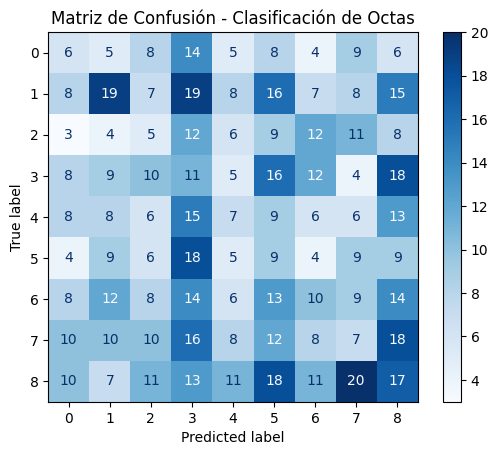

In [ ]:

# Matriz de confusión
cm = confusion_matrix(octa_true, y_pred_octa)
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(cm, display_labels=[str(i) for i in range(9)]).plot(cmap='Blues')
plt.title("Matriz de Confusión - Clasificación de Octas")
plt.savefig("matriz_confusion_octas.png")
plt.show()

# Métricas por clase
precision, recall, f1, _ = precision_recall_fscore_support(octa_true, y_pred_octa, labels=list(range(9)), zero_division=0)
accuracy = accuracy_score(octa_true, y_pred_octa)

df_metrics = pd.DataFrame({
    "Clase": list(range(9)),
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1
})
df_metrics.loc[len(df_metrics.index)] = ["Accuracy Global", accuracy, "", ""]
df_metrics.to_csv("metricas_modelo_octas.csv", index=False)

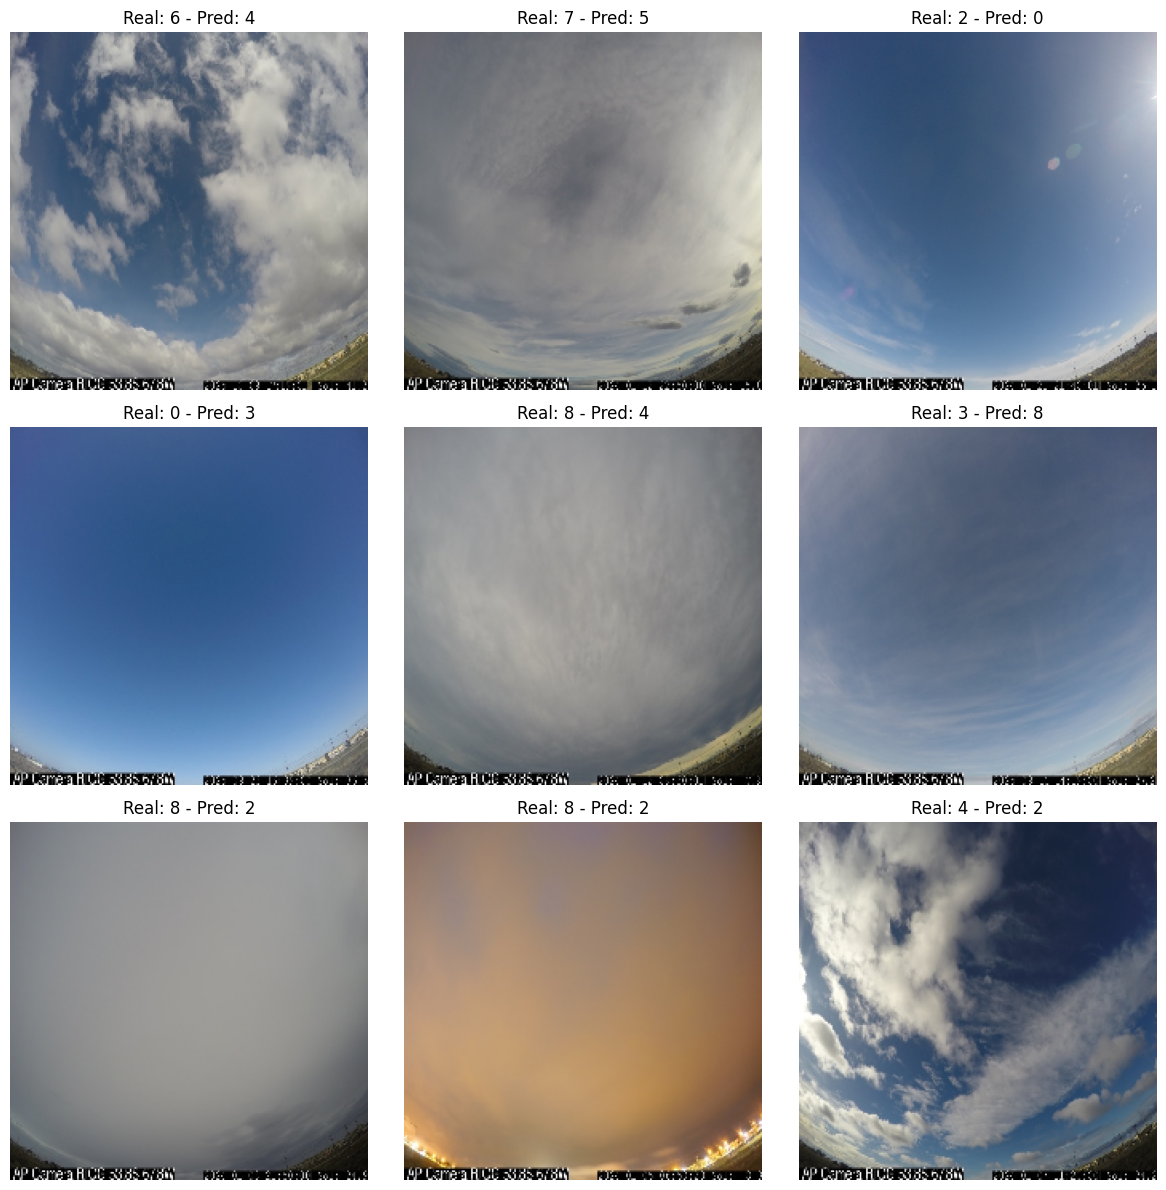

In [ ]:
# Visualización de errores
errores = [(path, true, pred) for path, true, pred in zip(val_paths, octa_true, y_pred_octa) if true != pred]
plt.figure(figsize=(12, 12))
for i, (path, true, pred) in enumerate(errores[:9]):
    img = load_img(path, target_size=(img_size, img_size))
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Real: {true} - Pred: {pred}")
    plt.axis('off')
plt.tight_layout()
plt.savefig("errores_clasificacion_octas.png")
plt.show()

Gráfico de aprendizaje

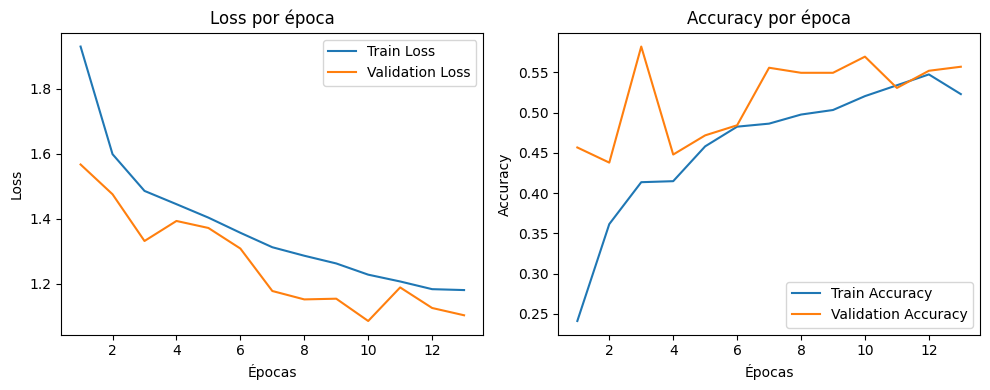

In [ ]:
# Gráfico de aprendizaje
hist = history.history
epochs = range(1, len(hist['loss']) + 1)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, hist['loss'], label='Train Loss')
plt.plot(epochs, hist['val_loss'], label='Validation Loss')
plt.title('Loss por época')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, hist['accuracy'], label='Train Accuracy')
plt.plot(epochs, hist['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy por época')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig("grafico_aprendizaje_octas.png")
plt.show()